In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
try:
    from tensorflow import keras
    from tensorflow.keras import layers, callbacks
except ImportError:
    import keras
    from keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')
import random


In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# ============================================================================
# CONFIG
# ============================================================================
TARGETS = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
TEMPORAL_FEATURES = ['hour', 'is_day', 'hour_sin', 'hour_cos', 'dow', 'dow_sin', 
                     'dow_cos', 'is_holiday', 'is_weekend', 'lockdown_code']

WEATHER_FEATURES = ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 
                    'apparent_temperature', 'pressure_msl', 'wind_speed_10m', 
                    'wind_direction_10m', 'precipitation', 'cloud_cover', 'cloud_cover_low',
                    'cloud_cover_mid', 'cloud_cover_high', 'shortwave_radiation', 
                    'direct_radiation', 'diffuse_radiation', 'global_tilted_irradiance', 
                    'wind_gusts_10m','vapour_pressure_deficit', 'et0_fao_evapotranspiration',
                    'snowfall', 'rain,showers' , 'weather_code']

SEQ_LENGTH = 24

In [3]:
train_df = pd.read_csv("../data/train_features.csv")
test_df = pd.read_csv("../data/test_features_to_predict.csv")
train_weather = pd.read_csv("../data/traindata_imputed.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")



Train shape: (40991, 213)
Test shape: (504, 208)


In [4]:
# ============================================================================
# PREPARE TRAINING DATA - RAW FEATURES ONLY (NO LAGS)
# ============================================================================
print("\nPreparing training data (raw features, no lags)...")

# Get weather columns that exist in train_weather
weather_cols = [w for w in WEATHER_FEATURES if w in train_weather.columns]
feature_cols = weather_cols + TEMPORAL_FEATURES

print(f"Using {len(feature_cols)} raw features for training")
print(f"  - Weather features: {len(weather_cols)}")
print(f"  - Temporal features: {len(TEMPORAL_FEATURES)}")

# Combine: weather from train_weather, temporal from train_df, targets from train_df
# Make sure they're aligned by index/datetime
train_combined = train_weather[weather_cols].copy()
for feat in TEMPORAL_FEATURES:
    if feat in train_df.columns:
        train_combined[feat] = train_df[feat].values
for target in TARGETS:
    if target in train_df.columns:
        train_combined[target] = train_df[target].values

# Remove rows with NaN
train_clean = train_combined[feature_cols + TARGETS].dropna()
print(f"Train samples after removing NaNs: {len(train_clean)}")

X_train_full = train_clean[feature_cols].values
Y_train_full = train_clean[TARGETS].values

# ============================================================================
# CREATE SEQUENCES FOR GRU (window-based approach)
# ============================================================================
print("\nCreating sequences for GRU...")


def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, Y_seq = create_sequences(X_train_full, Y_train_full, SEQ_LENGTH)
print(f"Sequences shape: {X_seq.shape}")  # (samples, 24, features)



Preparing training data (raw features, no lags)...
Using 31 raw features for training
  - Weather features: 21
  - Temporal features: 10
Train samples after removing NaNs: 40991

Creating sequences for GRU...
Sequences shape: (40967, 24, 31)


In [5]:

# ============================================================================
# TRAIN/VAL SPLIT (time-based)
# ============================================================================
split_idx = int(0.85 * len(X_seq))
X_train = X_seq[:split_idx]
Y_train = Y_seq[:split_idx]
X_val = X_seq[split_idx:]
Y_val = Y_seq[split_idx:]

print(f"\nTrain sequences: {X_train.shape}")
print(f"Val sequences: {X_val.shape}")

# ============================================================================
# SCALE FEATURES
# ============================================================================
print("\nScaling features...")

# Reshape for scaling
n_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)
X_val_reshaped = X_val.reshape(-1, n_features)

scaler = StandardScaler()
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)

X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
X_val_scaled = X_val_scaled_reshaped.reshape(X_val.shape)

# Scale targets
target_scalers = {}
Y_train_scaled = np.zeros_like(Y_train, dtype=np.float32)
Y_val_scaled = np.zeros_like(Y_val, dtype=np.float32)

for i, target in enumerate(TARGETS):
    scaler_t = StandardScaler()
    Y_train_scaled[:, i] = scaler_t.fit_transform(Y_train[:, i:i+1]).ravel()
    Y_val_scaled[:, i] = scaler_t.transform(Y_val[:, i:i+1]).ravel()
    target_scalers[target] = scaler_t


Train sequences: (34821, 24, 31)
Val sequences: (6146, 24, 31)

Scaling features...


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.optimizers import AdamW

# === MODEL PARAMETERS ===
SEQ_LENGTH = X_train.shape[1]       # e.g. 24
N_FEATURES = X_train.shape[2]
N_TARGETS = Y_train.shape[1]

# === BUILD MODEL ===
model = keras.Sequential([
    # First GRU layer
    layers.GRU(
        64, 
        return_sequences=True, 
        input_shape=(SEQ_LENGTH, N_FEATURES),
        dropout=0.4, 
        recurrent_dropout=0.3,
        kernel_regularizer=regularizers.l2(0.001)
    ),

    # Second GRU layer
    layers.GRU(
        32, 
        return_sequences=False, 
        dropout=0.4, 
        recurrent_dropout=0.3,
        kernel_regularizer=regularizers.l2(0.001)
    ),
    
    # Dense block with L2 regularization
    layers.Dense(
        32, 
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ),
    layers.Dropout(0.3),

    # Slightly smaller final hidden layer to avoid overfitting
    layers.Dense(
        16, 
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ),
    
    # Output layer
    layers.Dense(N_TARGETS)
])

# === OPTIMIZER ===
optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-2)

# === COMPILE MODEL ===
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

print(model.summary())

# === CALLBACKS ===
cb_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-5
    ),
    callbacks.ModelCheckpoint(
        filepath='best_gru_model.keras',
        save_best_only=True,
        monitor='val_loss'
    )
]



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 24, 64)         │        18,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,701 (116.02 KB)

 Trainable params: 29,701 (116.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:


history = model.fit(
    X_train_scaled, Y_train_scaled,
    validation_data=(X_val_scaled, Y_val_scaled),
    epochs=100,
    batch_size=64,
    callbacks=cb_list,
    verbose=1
)

# ============================================================================
# VALIDATION METRICS
# ============================================================================
print("\nValidation MAE per pollutant:")
Y_val_pred_scaled = model.predict(X_val_scaled, verbose=0)
mae_per_pollutant = []
for i, target in enumerate(TARGETS):
    y_pred_unscaled = target_scalers[target].inverse_transform(Y_val_pred_scaled[:, i:i+1])
    mae = mean_absolute_error(Y_val[:, i], y_pred_unscaled)
    mae_per_pollutant.append(mae)
    print(f"  {target}: {mae:.4f}")
final_score_val = np.mean(mae_per_pollutant)
print(f"\nValidation Final Score (avg MAE): {final_score_val:.4f}")


Epoch 1/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 0.8590 - mae: 0.6042 - val_loss: 0.4916 - val_mae: 0.4586 - learning_rate: 0.0010
Epoch 2/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.7157 - mae: 0.5573 - val_loss: 0.4515 - val_mae: 0.4392 - learning_rate: 0.0010
Epoch 3/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.6637 - mae: 0.5373 - val_loss: 0.4441 - val_mae: 0.4351 - learning_rate: 0.0010
Epoch 4/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.6349 - mae: 0.5240 - val_loss: 0.4274 - val_mae: 0.4208 - learning_rate: 0.0010
Epoch 5/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.6120 - mae: 0.5159 - val_loss: 0.4319 - val_mae: 0.4261 - learning_rate: 0.0010
Epoch 6/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.6012 - mae: 0.5105 - val_loss: 0.4174 - val_mae: 0.4133 - learning_rate: 0.0010
Epoch 7/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.5903 - mae: 0.5065 - val_loss: 0.4139 - val_mae: 0.4101 - learnin

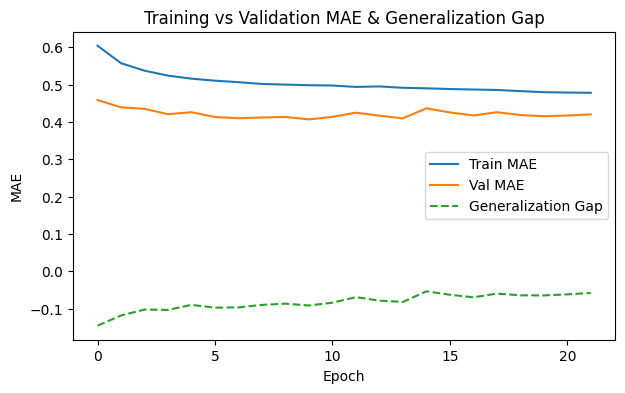

In [9]:
import matplotlib.pyplot as plt

train_mae = history.history['mae']
val_mae = history.history['val_mae']
gen_gap = [v - t for v, t in zip(val_mae, train_mae)]

plt.figure(figsize=(7,4))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.plot(gen_gap, '--', label='Generalization Gap')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training vs Validation MAE & Generalization Gap')
plt.show()


In [8]:
# ============================================================================
# AUTO-REGRESSIVE TEST PREDICTION
# ============================================================================
print("\n" + "="*70)
print("AUTO-REGRESSIVE TEST PREDICTION")
print("="*70)

# Step 1: Get last SEQ_LENGTH rows from training data as initial sequence
print(f"\nStep 1: Initialize with last {SEQ_LENGTH} hours from training...")
initial_sequence = X_train_full[-SEQ_LENGTH:].copy()
print(f"Initial sequence shape: {initial_sequence.shape}")

# Step 2: Create weather predictor model (optional but helpful)
# Since we don't have weather for test, we'll use simple persistence
# (assume weather stays similar to last known values)
print("\nStep 2: Prepare weather persistence (last known averages)...")
last_weather_mean = {}
for i, col in enumerate(feature_cols):
    if col in weather_cols:
        # Use mean of last 24 hours as baseline
        last_weather_mean[col] = initial_sequence[-24:, i].mean()
    else:
        last_weather_mean[col] = 0  # Will be updated from test_df

print(f"Weather features to persist: {len([k for k in last_weather_mean.keys() if k in weather_cols])}")

# Step 3: Iterative prediction
print(f"\nStep 3: Predicting {len(test_df)} test samples iteratively...")
test_predictions = []
current_sequence = initial_sequence.copy()

for idx in range(len(test_df)):
    if idx % 100 == 0:
        print(f"  Predicting sample {idx}/{len(test_df)}...")
    
    test_row = test_df.iloc[idx]
    
    # Scale current sequence
    current_sequence_flat = current_sequence.reshape(-1, n_features)
    current_sequence_scaled_flat = scaler.transform(current_sequence_flat)
    current_sequence_scaled = current_sequence_scaled_flat.reshape(1, SEQ_LENGTH, n_features)
    
    # Predict pollutants (scaled)
    pred_scaled = model.predict(current_sequence_scaled, verbose=0)
    
    # Unscale predictions
    pred_unscaled = np.zeros(n_targets)
    for i, target in enumerate(TARGETS):
        pred_unscaled[i] = target_scalers[target].inverse_transform(pred_scaled[:, i:i+1]).ravel()[0]
    
    test_predictions.append(pred_unscaled)
    
    # Build next input: [weather_features, temporal_features]
    next_input = np.zeros(n_features)
    
    # Weather: use persistence (or predicted if you had a weather model)
    for i, col in enumerate(feature_cols):
        if col in weather_cols:
            # Simple persistence: use last known mean
            next_input[i] = last_weather_mean[col]
        elif col in TEMPORAL_FEATURES and col in test_row.index:
            # Temporal: use actual from test_df
            next_input[i] = test_row[col]
        else:
            next_input[i] = 0
    
    # Update sequence: shift left and append new input
    current_sequence = np.vstack([current_sequence[1:], next_input])

test_predictions = np.array(test_predictions)
print(f"✅ Test predictions shape: {test_predictions.shape}")


AUTO-REGRESSIVE TEST PREDICTION

Step 1: Initialize with last 24 hours from training...
Initial sequence shape: (24, 31)

Step 2: Prepare weather persistence (last known averages)...
Weather features to persist: 21

Step 3: Predicting 504 test samples iteratively...
  Predicting sample 0/504...
  Predicting sample 100/504...
  Predicting sample 200/504...
  Predicting sample 300/504...
  Predicting sample 400/504...
  Predicting sample 500/504...
✅ Test predictions shape: (504, 5)



Creating submission file...
✅ Submission saved to gru_autoregressive_submission.csv

Submission preview:
              id  valeur_NO2  valeur_CO  valeur_O3  valeur_PM10  valeur_PM25
0  2024-09-03 23   27.262949   0.212856  36.086727    15.419501     9.325003
1  2024-09-04 00   22.056772   0.192701  40.656773    14.096536     8.278748
2  2024-09-04 01   18.454445   0.176686  44.408993    13.074729     7.459817
3  2024-09-04 02   18.296095   0.174876  43.759167    12.971719     7.303106
4  2024-09-04 03   19.604279   0.176788  42.550709    13.209714     7.129297
Submission shape: (504, 6)


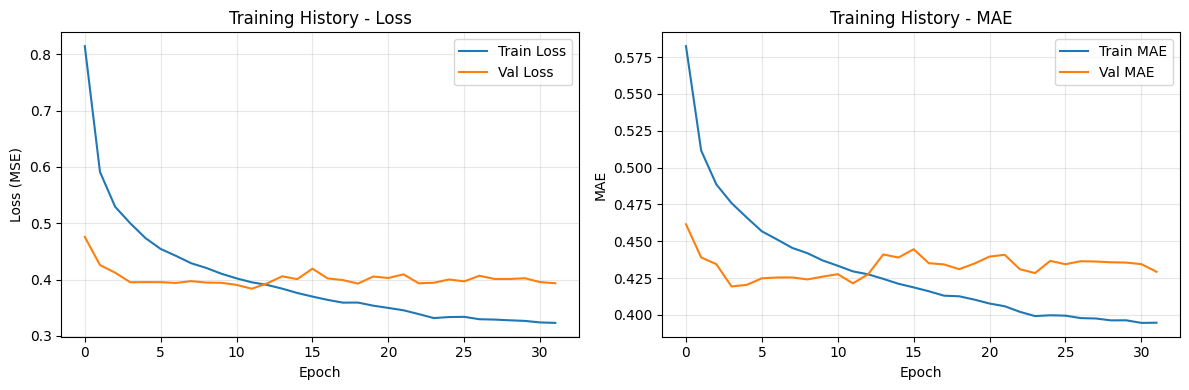

✅ Training history saved to gru_autoregressive_training.png


In [9]:
# ============================================================================
# CREATE SUBMISSION
# ============================================================================
print("\nCreating submission file...")
submission = pd.DataFrame()
submission['id'] = test_df['id'].values
for i, target in enumerate(TARGETS):
    submission[target] = test_predictions[:, i]

submission.to_csv('gru_autoregressive_submission.csv', index=False)
print("✅ Submission saved to gru_autoregressive_submission.csv")
print(f"\nSubmission preview:\n{submission.head()}")
print(f"Submission shape: {submission.shape}")

# ============================================================================
# PLOT TRAINING HISTORY
# ============================================================================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training History - Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training History - MAE')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gru_autoregressive_training.png', dpi=100, bbox_inches='tight')
plt.show()
print("✅ Training history saved to gru_autoregressive_training.png")
